# 🎵 Spotify Tracks Dataset — XGBoost Experiments

This repository uses the **Spotify Tracks Dataset** from Kaggle, which contains a large collection of Spotify songs spanning **125 different genres**, along with their associated **audio features**.

🔗 Dataset source:  
[Spotify Tracks Dataset on Kaggle](https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset)

---

## 📊 Dataset Overview

Each row in the dataset corresponds to a single Spotify track and includes:
- Track metadata (e.g. artist, track name)
- Audio features extracted by Spotify (e.g. danceability, energy, tempo, loudness)
- A genre label for each track

The dataset is provided in **CSV format**, making it easy and efficient to load and process using standard Python data science tools such as `pandas`.

---

## 🎯 Intended Use in This Repository

In this repository, the dataset is used for **supervised machine learning experiments with XGBoost**, focusing on:

- **Genre classification** based on audio features  
- Exploring feature importance and model interpretability  
- Benchmarking gradient-boosted decision trees on structured audio data  

Because the data is fully **tabular**, it is particularly well-suited for tree-based models such as **XGBoost**, without requiring feature engineering typical of raw audio processing.

---

## 📥 Setup Instructions

1. Download the dataset from Kaggle using the link above.
2. Extract the CSV file.
3. Place the CSV file in the **same directory as this notebook**.

Once the file is available locally, the notebook will load it directly and proceed with preprocessing and model training.

---

This setup provides a clean and reproducible starting point for experimenting with **XGBoost on music-related tabular data**.


## Dataset Download

In [5]:
#!/bin/bash
DATASET_DIR = "./workdir/xgboost"
URL_ADD = "https://www.kaggle.com/api/v1/datasets/download/maharshipandya/-spotify-tracks-dataset"

!curl -L -o {DATASET_DIR}/spotify-tracks-dataset.zip {URL_ADD}
!unzip {DATASET_DIR}/spotify-tracks-dataset.zip -d {DATASET_DIR}/
!rm {DATASET_DIR}/spotify-tracks-dataset.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 8370k  100 8370k    0     0  5095k      0  0:00:01  0:00:01 --:--:-- 6317k
Archive:  ./workdir/xgboost/spotify-tracks-dataset.zip
  inflating: ./workdir/xgboost/dataset.csv  


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import os 

### 📥 Loading the Dataset

Loads the Spotify Tracks dataset from a CSV file into a pandas DataFrame and displays the first few rows to inspect the data structure, available features, and sample values before further analysis or modeling.

In [17]:
spotify_tracks = pd.read_csv(os.path.join(DATASET_DIR, 'dataset.csv'))
spotify_tracks.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


### 🎼 Exploring Genre Labels

Retrieves the list of unique music genres present in the dataset, providing an overview of the classification labels available for modeling and highlighting the diversity of genres covered.

In [18]:
spotify_tracks['track_genre'].unique()

array(['acoustic', 'afrobeat', 'alt-rock', 'alternative', 'ambient',
       'anime', 'black-metal', 'bluegrass', 'blues', 'brazil',
       'breakbeat', 'british', 'cantopop', 'chicago-house', 'children',
       'chill', 'classical', 'club', 'comedy', 'country', 'dance',
       'dancehall', 'death-metal', 'deep-house', 'detroit-techno',
       'disco', 'disney', 'drum-and-bass', 'dub', 'dubstep', 'edm',
       'electro', 'electronic', 'emo', 'folk', 'forro', 'french', 'funk',
       'garage', 'german', 'gospel', 'goth', 'grindcore', 'groove',
       'grunge', 'guitar', 'happy', 'hard-rock', 'hardcore', 'hardstyle',
       'heavy-metal', 'hip-hop', 'honky-tonk', 'house', 'idm', 'indian',
       'indie-pop', 'indie', 'industrial', 'iranian', 'j-dance', 'j-idol',
       'j-pop', 'j-rock', 'jazz', 'k-pop', 'kids', 'latin', 'latino',
       'malay', 'mandopop', 'metal', 'metalcore', 'minimal-techno', 'mpb',
       'new-age', 'opera', 'pagode', 'party', 'piano', 'pop-film', 'pop',
       'pow

### 🎯 Selecting Target Genres

Filters the dataset to retain only tracks belonging to a selected subset of genres (`pop`, `country`, `hip-hop`, `punk-rock`, `latin`, and `edm`), reducing the problem to a focused multi-class classification task.

In [19]:
spotify_tracks = spotify_tracks[spotify_tracks['track_genre'].isin(['pop', 'country', 'hip-hop', 'punk-rock', 'latin', 'edm'])]

### 🧹 Data Cleaning and Preparation

Removes non-numeric and irrelevant metadata columns that are not useful for model training, checks for missing values across features, and drops any rows containing missing data to ensure a clean input for downstream modeling.

In [20]:
spotify_tracks.drop(columns=["Unnamed: 0", "track_id", "track_name", "artists", "album_name", "time_signature"], axis=1, inplace=True)
print(spotify_tracks.isnull().sum())
spotify_tracks.dropna(inplace=True)

popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
track_genre         0
dtype: int64


### 🔀 Defining Features and Data Splits

Separates the dataset into input features and the target genre labels, then splits the data into training, validation, and test sets. This setup enables model training, hyperparameter tuning on the validation set, and unbiased performance evaluation on the test set.

In [21]:
X, y = spotify_tracks.loc[ : , (spotify_tracks.columns != 'track_genre')], spotify_tracks['track_genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

### 🔢 Encoding Genre Labels

Converts the categorical genre labels into numeric class indices using `LabelEncoder`, making the target variable compatible with machine learning models such as XGBoost while ensuring consistent encoding across training, validation, and test sets.

In [22]:
label_encoder = LabelEncoder()
y_train= label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

### 📐 Feature Scaling

Standardizes the input features to have zero mean and unit variance using `StandardScaler`. The scaler is fit on the training data and applied consistently to the validation and test sets to ensure comparable feature distributions during model training and evaluation.

In [23]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

### 🚀 Training and Evaluating the XGBoost Model

Trains an XGBoost classifier on the standardized training data and evaluates its performance on the validation set. The model’s accuracy is reported along with a detailed classification report and confusion matrix, providing insight into class-wise performance and potential misclassifications.

In [24]:
xgb_classifier = xgb.XGBClassifier(random_state=42)
xgb_classifier.fit(X_train, y_train)
y_pred = xgb_classifier.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_val, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred))

Validation Accuracy: 0.7083

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.83      0.78       197
           1       0.77      0.73      0.75       208
           2       0.63      0.60      0.61       206
           3       0.70      0.63      0.66       202
           4       0.57      0.62      0.59       185
           5       0.84      0.84      0.84       202

    accuracy                           0.71      1200
   macro avg       0.71      0.71      0.71      1200
weighted avg       0.71      0.71      0.71      1200


Confusion Matrix:
 [[164   3   3   6   9  12]
 [ 10 152  12   5  19  10]
 [  3  14 123  28  36   2]
 [ 18   7  25 127  20   5]
 [ 11  15  27  14 115   3]
 [ 18   7   4   1   3 169]]


### 🔍 Hyperparameter Tuning with Randomized Search

Defines a search space of key XGBoost hyperparameters and applies `RandomizedSearchCV` with cross-validation to identify an optimal model configuration. This approach efficiently explores the parameter space, balances performance and computational cost, and selects the best-performing estimator based on validation accuracy.

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.85, 1.0],
    'colsample_bytree': [0.7, 0.85, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 1, 10, 100],
    'reg_lambda': [0.5, 0.7, 1, 1.3]
}

xgb_model = xgb.XGBClassifier(random_state=42)
grid_search = RandomizedSearchCV(xgb_model, param_grid, cv=10, scoring="accuracy", n_iter=10, n_jobs=-1, verbose=2, random_state=42) # reduced n_iter to 10
grid_search.fit(X_train, y_train)
best_xgb = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)


### ✅ Final Evaluation on the Test Set

Uses the best-performing XGBoost model from hyperparameter tuning to make predictions on the held-out test set. Reports the overall test accuracy along with a detailed classification report and confusion matrix to assess the model’s generalization performance and class-wise prediction quality.

In [26]:
y_pred = best_xgb.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Test Accuracy: 0.7233

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.80      0.77       215
           1       0.80      0.72      0.76       222
           2       0.67      0.62      0.64       176
           3       0.71      0.67      0.69       204
           4       0.60      0.68      0.64       189
           5       0.81      0.83      0.82       194

    accuracy                           0.72      1200
   macro avg       0.72      0.72      0.72      1200
weighted avg       0.73      0.72      0.72      1200


Confusion Matrix:
 [[172   3   2   5  18  15]
 [  7 160  11   4  27  13]
 [  6   6 109  28  24   3]
 [ 25   7  18 137  14   3]
 [  7  16  19  14 129   4]
 [ 12   9   4   4   4 161]]


### 📊 Feature Importance Analysis

Extracts feature importance scores from the trained XGBoost model and visualizes them in descending order. This plot highlights which audio features contribute most to the genre classification task, offering insight into the model’s decision-making process.

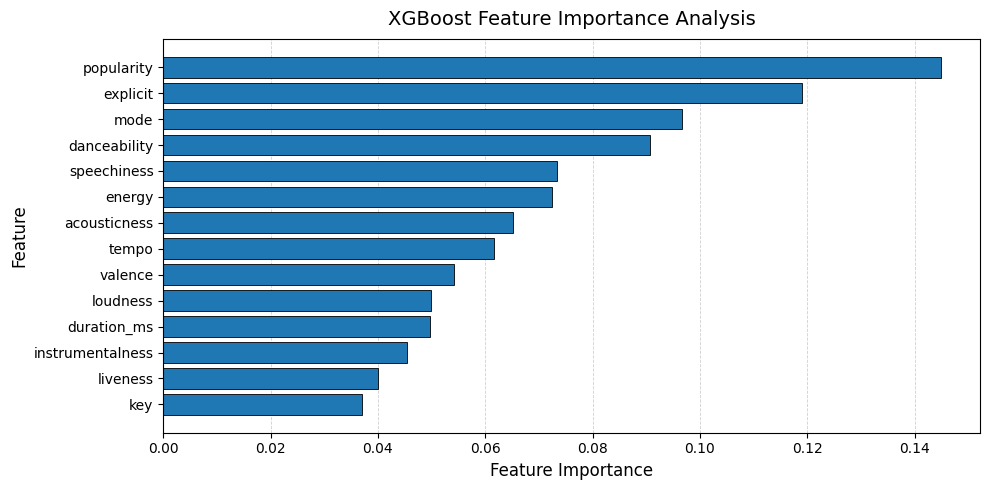

In [31]:
importances = best_xgb.feature_importances_
features = np.array(X.columns)

idx = np.argsort(importances)[::-1]
importances = importances[idx]
features = features[idx]

fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(features, importances, edgecolor="black", linewidth=0.6)
ax.invert_yaxis()

ax.set_xlabel("Feature Importance", fontsize=12)
ax.set_ylabel("Feature", fontsize=12)
ax.set_title("XGBoost Feature Importance Analysis", fontsize=14, pad=10)

ax.grid(axis="x", linestyle="--", linewidth=0.6, alpha=0.6)
ax.set_axisbelow(True)
ax.tick_params(axis="both", labelsize=10)
fig.tight_layout()
plt.show()

### ⚖️ Class Distribution and Imbalance Analysis

Computes and displays the distribution and relative proportions of genre labels in the dataset, followed by a bar chart visualization for intuitive inspection. An imbalance ratio is then calculated to quantify class imbalance, with a brief diagnostic message indicating whether mitigation strategies such as class weighting or resampling may be necessary.

Class distribution:
track_genre
country      1000
edm          1000
hip-hop      1000
latin        1000
pop          1000
punk-rock    1000
Name: count, dtype: int64

Class proportions:
track_genre
country      0.166667
edm          0.166667
hip-hop      0.166667
latin        0.166667
pop          0.166667
punk-rock    0.166667
Name: proportion, dtype: float64


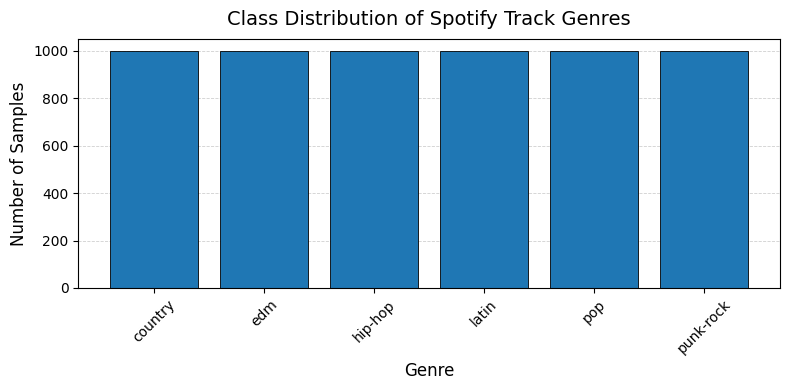


Imbalance ratio (max/min): 1.00
✅ Class distribution is relatively balanced.


In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Class distribution
class_counts = y.value_counts()
class_proportions = y.value_counts(normalize=True)

print("Class distribution:")
print(class_counts)
print("\nClass proportions:")
print(class_proportions)

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(class_counts.index, class_counts.values, edgecolor="black", linewidth=0.6)
ax.set_title("Class Distribution of Spotify Track Genres", fontsize=14, pad=10)
ax.set_xlabel("Genre", fontsize=12)
ax.set_ylabel("Number of Samples", fontsize=12)
ax.tick_params(axis="x", rotation=45, labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.6)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()

# Imbalance analysis
max_count = class_counts.max()
min_count = class_counts.min()
imbalance_ratio = max_count / min_count
print(f"\nImbalance ratio (max/min): {imbalance_ratio:.2f}")
if imbalance_ratio > 2:
    print("⚠️ Significant class imbalance detected.")
    print("Recommended: class weighting or resampling techniques (e.g., SMOTE).")
else:
    print("✅ Class distribution is relatively balanced.")

# 🚨 Handling Extreme Class Imbalance

### ⚠️ Creating an Artificially Imbalanced Dataset

Constructs a deliberately imbalanced version of the dataset by heavily downsampling selected genres while retaining different proportions of others. This setup is used to simulate real-world class imbalance scenarios, enabling analysis of model robustness and the impact of imbalance on classification performance.

In [35]:
# Create an extremely imbalanced dataset
# Keep only 5% of 'pop' and 'country' samples, but keep all others
imbalanced_data = spotify_tracks.copy()

# Get indices for pop and country
pop_indices = imbalanced_data[imbalanced_data['track_genre'] == 'pop'].index
country_indices = imbalanced_data[imbalanced_data['track_genre'] == 'country'].index
edm_indices = imbalanced_data[imbalanced_data['track_genre'] == 'edm'].index
latin_indices = imbalanced_data[imbalanced_data['track_genre'] == 'latin'].index
hiphop_indices = imbalanced_data[imbalanced_data['track_genre'] == 'hip-hop'].index
punk_indices = imbalanced_data[imbalanced_data['track_genre'] == 'punk-rock'].index
# Randomly sample 5% of pop and country
np.random.seed(42)
pop_sample = np.random.choice(pop_indices, size=int(len(pop_indices) * 0.07), replace=False)
country_sample = np.random.choice(country_indices, size=int(len(country_indices) * 0.05), replace=False)
edm_sample = np.random.choice(edm_indices, size=int(len(edm_indices) * 0.55), replace=False)
latin_sample = np.random.choice(latin_indices, size=int(len(latin_indices) * 0.06), replace=False)
hiphop_sample = np.random.choice(hiphop_indices, size=int(len(hiphop_indices) * 0.09), replace=False)
punk_sample = np.random.choice(punk_indices, size=int(len(punk_indices) * 0.29), replace=False)
# Remove the non-sampled pop and country tracks
indices_to_remove = set(pop_indices) - set(pop_sample)
indices_to_remove.update(set(country_indices) - set(country_sample))
indices_to_remove.update(set(edm_indices) - set(edm_sample))
indices_to_remove.update(set(latin_indices) - set(latin_sample))
indices_to_remove.update(set(hiphop_indices) - set(hiphop_sample))
indices_to_remove.update(set(punk_indices) - set(punk_sample))

imbalanced_data = imbalanced_data.drop(indices_to_remove)

print("Original dataset shape:", spotify_tracks.shape)
print("Imbalanced dataset shape:", imbalanced_data.shape)
print("\nClass distribution in imbalanced dataset:")
print(imbalanced_data['track_genre'].value_counts())


Original dataset shape: (6000, 15)
Imbalanced dataset shape: (1110, 15)

Class distribution in imbalanced dataset:
track_genre
edm          550
punk-rock    290
hip-hop       90
pop           70
latin         60
country       50
Name: count, dtype: int64


### 📉 Visualizing and Quantifying Extreme Class Imbalance

Visualizes the genre distribution of the artificially imbalanced dataset using a bar chart to clearly highlight the disproportionate class representation. Quantitative imbalance metrics are then computed, including the imbalance ratio and minority class percentage, to formally characterize the severity of the imbalance and confirm the presence of an extreme class imbalance scenario.

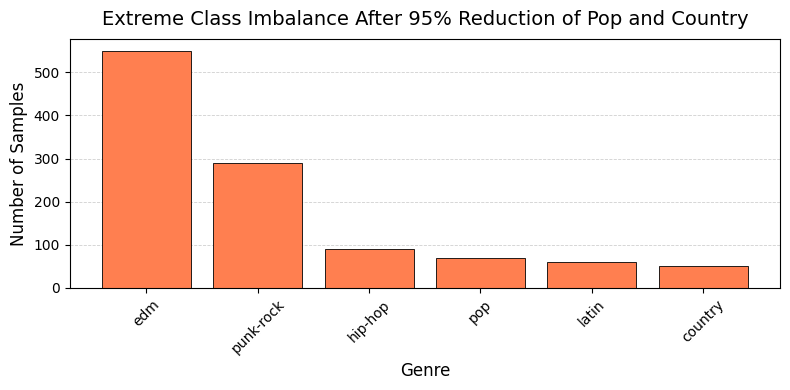

Imbalance ratio (max/min): 11.00
Minority class percentage: 4.50%
⚠️ EXTREME class imbalance detected.


In [38]:
class_counts = imbalanced_data['track_genre'].value_counts()

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(class_counts.index, class_counts.values, color="coral", edgecolor="black", linewidth=0.6)

ax.set_title("Extreme Class Imbalance After 95% Reduction of Pop and Country", fontsize=14, pad=10)
ax.set_xlabel("Genre", fontsize=12)
ax.set_ylabel("Number of Samples", fontsize=12)
ax.tick_params(axis="x", rotation=45, labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.6)
ax.set_axisbelow(True)
fig.tight_layout()
plt.show()

# Imbalance metrics
max_count = class_counts.max()
min_count = class_counts.min()
imbalance_ratio = max_count / min_count
minority_percentage = (min_count / len(imbalanced_data)) * 100

print(f"Imbalance ratio (max/min): {imbalance_ratio:.2f}")
print(f"Minority class percentage: {minority_percentage:.2f}%")
print("⚠️ EXTREME class imbalance detected.")

### 🛠️ Preparing the Imbalanced Dataset for Modeling

Separates features and target labels from the imbalanced dataset, then performs stratified train, validation, and test splits to preserve class proportions across splits. The genre labels are encoded into numeric classes, and all features are standardized to ensure consistent scaling before model training. Finally, class distributions in the training and validation sets are printed to verify that the imbalance is correctly reflected.

In [40]:
X_imb, y_imb = imbalanced_data.loc[:, (imbalanced_data.columns != 'track_genre')], imbalanced_data['track_genre']

X_train_imb, X_test_imb, y_train_imb, y_test_imb = train_test_split(X_imb, y_imb, test_size=0.2, random_state=42, stratify=y_imb)
X_train_imb, X_val_imb, y_train_imb, y_val_imb = train_test_split(X_train_imb, y_train_imb, test_size=0.25, random_state=42, stratify=y_train_imb)

label_encoder_imb = LabelEncoder()
y_train_imb_encoded = label_encoder_imb.fit_transform(y_train_imb)
y_val_imb_encoded = label_encoder_imb.transform(y_val_imb)
y_test_imb_encoded = label_encoder_imb.transform(y_test_imb)

scaler_imb = StandardScaler()
X_train_imb_scaled = scaler_imb.fit_transform(X_train_imb)
X_val_imb_scaled = scaler_imb.transform(X_val_imb)
X_test_imb_scaled = scaler_imb.transform(X_test_imb)

print("Training set class distribution:")
print(pd.Series(y_train_imb_encoded).value_counts().sort_index())
print("\nValidation set class distribution:")
print(pd.Series(y_val_imb_encoded).value_counts().sort_index())


Training set class distribution:
0     30
1    330
2     54
3     36
4     42
5    174
Name: count, dtype: int64

Validation set class distribution:
0     10
1    110
2     18
3     12
4     14
5     58
Name: count, dtype: int64


## 🎯 Model 1: Standard XGBoost (No Imbalance Handling)

**Training a Baseline XGBoost Model on Imbalanced Data:** Trains a standard XGBoost classifier on the imbalanced dataset without any explicit imbalance handling. The model is evaluated on the validation set using accuracy, a detailed classification report, and a confusion matrix to establish a baseline performance under severe class imbalance.

In [41]:
xgb_standard = xgb.XGBClassifier(random_state=42)
xgb_standard.fit(X_train_imb_scaled, y_train_imb_encoded)

y_pred_standard = xgb_standard.predict(X_val_imb_scaled)
val_accuracy_standard = accuracy_score(y_val_imb_encoded, y_pred_standard)
print(f"Standard XGBoost Validation Accuracy: {val_accuracy_standard:.4f}")

print("\nClassification Report (Standard XGBoost):")
print(classification_report(y_val_imb_encoded, y_pred_standard, 
                          target_names=label_encoder_imb.classes_))

print("\nConfusion Matrix (Standard XGBoost):")
print(confusion_matrix(y_val_imb_encoded, y_pred_standard))


Standard XGBoost Validation Accuracy: 0.7748

Classification Report (Standard XGBoost):
              precision    recall  f1-score   support

     country       0.67      0.20      0.31        10
         edm       0.79      0.91      0.84       110
     hip-hop       0.75      0.33      0.46        18
       latin       0.58      0.58      0.58        12
         pop       0.78      0.50      0.61        14
   punk-rock       0.79      0.86      0.83        58

    accuracy                           0.77       222
   macro avg       0.73      0.56      0.61       222
weighted avg       0.77      0.77      0.76       222


Confusion Matrix (Standard XGBoost):
[[  2   2   0   0   1   5]
 [  0 100   1   1   1   7]
 [  0   9   6   3   0   0]
 [  0   4   1   7   0   0]
 [  0   6   0   0   7   1]
 [  1   6   0   1   0  50]]


## ⚖️ Model 2: XGBoost with Class Weights (multiclass via sample_weight)

**Handling Class Imbalance with Sample-Weighted XGBoost:** Computes inverse-frequency class weights from the imbalanced training set and assigns them as per-sample weights to emphasize minority classes during training. An XGBoost classifier is then trained using these weights and evaluated on the validation set, allowing comparison against the unweighted baseline to assess the impact of imbalance-aware learning.

In [42]:
train_class_counts = pd.Series(y_train_imb_encoded).value_counts().sort_index()
num_classes = len(train_class_counts)
class_weights = {cls: (len(y_train_imb_encoded) / (num_classes * count)) for cls, count in train_class_counts.items()}

sample_weight_train = np.array([class_weights[label] for label in y_train_imb_encoded])
xgb_weighted = xgb.XGBClassifier(random_state=42)
xgb_weighted.fit(X_train_imb_scaled, y_train_imb_encoded, sample_weight=sample_weight_train)

y_pred_weighted = xgb_weighted.predict(X_val_imb_scaled)
val_accuracy_weighted = accuracy_score(y_val_imb_encoded, y_pred_weighted)
print(f"Weighted XGBoost Validation Accuracy: {val_accuracy_weighted:.4f}")

print("\nClassification Report (Weighted XGBoost):")
print(classification_report(y_val_imb_encoded, y_pred_weighted, 
                          target_names=label_encoder_imb.classes_))

print("\nConfusion Matrix (Weighted XGBoost):")
print(confusion_matrix(y_val_imb_encoded, y_pred_weighted))

Weighted XGBoost Validation Accuracy: 0.7658

Classification Report (Weighted XGBoost):
              precision    recall  f1-score   support

     country       0.33      0.20      0.25        10
         edm       0.81      0.89      0.85       110
     hip-hop       0.53      0.44      0.48        18
       latin       0.55      0.50      0.52        12
         pop       0.78      0.50      0.61        14
   punk-rock       0.82      0.84      0.83        58

    accuracy                           0.77       222
   macro avg       0.64      0.56      0.59       222
weighted avg       0.75      0.77      0.75       222


Confusion Matrix (Weighted XGBoost):
[[ 2  2  0  0  1  5]
 [ 1 98  3  2  1  5]
 [ 1  6  8  3  0  0]
 [ 0  3  3  6  0  0]
 [ 0  6  0  0  7  1]
 [ 2  6  1  0  0 49]]


## 📊 Model 3: XGBoost with SMOTE (Synthetic Minority Oversampling)

**Addressing Class Imbalance with SMOTE:** Installs and imports the `imbalanced-learn` library if necessary, then applies **SMOTE (Synthetic Minority Over-sampling Technique)** to the imbalanced training set. SMOTE generates synthetic samples for minority classes to create a more balanced class distribution, which can help improve model performance in severely imbalanced classification tasks.

In [45]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_imb_scaled, y_train_imb_encoded)

print("Original training set shape:", X_train_imb_scaled.shape)
print("After SMOTE training set shape:", X_train_smote.shape)
print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts().sort_index())


Original training set shape: (666, 14)
After SMOTE training set shape: (1980, 14)

Class distribution after SMOTE:
0    330
1    330
2    330
3    330
4    330
5    330
Name: count, dtype: int64


In [46]:
xgb_smote = xgb.XGBClassifier(random_state=42)
xgb_smote.fit(X_train_smote, y_train_smote)

y_pred_smote = xgb_smote.predict(X_val_imb_scaled)
val_accuracy_smote = accuracy_score(y_val_imb_encoded, y_pred_smote)
print(f"SMOTE XGBoost Validation Accuracy: {val_accuracy_smote:.4f}")

print("\nClassification Report (SMOTE XGBoost):")
print(classification_report(y_val_imb_encoded, y_pred_smote, 
                          target_names=label_encoder_imb.classes_))

print("\nConfusion Matrix (SMOTE XGBoost):")
print(confusion_matrix(y_val_imb_encoded, y_pred_smote))

SMOTE XGBoost Validation Accuracy: 0.7613

Classification Report (SMOTE XGBoost):
              precision    recall  f1-score   support

     country       0.43      0.30      0.35        10
         edm       0.86      0.83      0.84       110
     hip-hop       0.57      0.44      0.50        18
       latin       0.50      0.83      0.62        12
         pop       0.67      0.43      0.52        14
   punk-rock       0.77      0.88      0.82        58

    accuracy                           0.76       222
   macro avg       0.63      0.62      0.61       222
weighted avg       0.76      0.76      0.76       222


Confusion Matrix (SMOTE XGBoost):
[[ 3  1  0  1  1  4]
 [ 2 91  4  3  2  8]
 [ 0  6  8  3  0  1]
 [ 0  1  1 10  0  0]
 [ 1  5  0  0  6  2]
 [ 1  2  1  3  0 51]]


## 📊 Comparing Imbalance Handling Strategies

Aggregates validation accuracy results from three different approaches—standard XGBoost, sample-weighted XGBoost, and SMOTE-based XGBoost—into a single table and bar chart for direct comparison. This visualization highlights how different imbalance mitigation strategies affect model performance and supports qualitative analysis of trade-offs, particularly in terms of minority class behavior.

Model Performance Comparison:
              Model  Validation Accuracy
0  Standard XGBoost             0.774775
1  Weighted XGBoost             0.765766
2     SMOTE XGBoost             0.761261


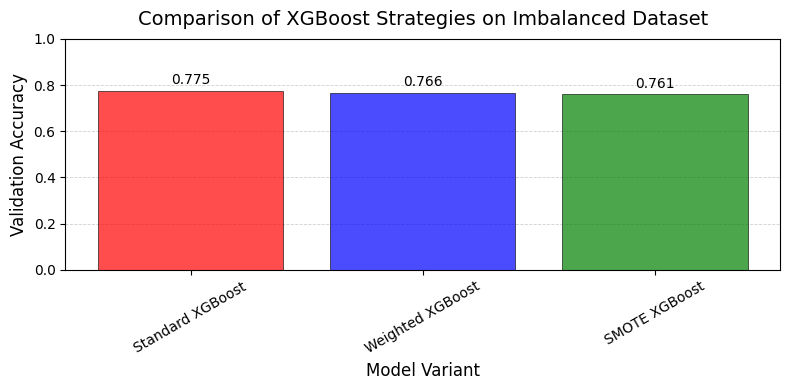


🔍 Key Insights:
1. Standard XGBoost is biased toward majority classes under severe imbalance.
2. Weighted XGBoost mitigates bias via inverse-frequency sample weighting.
3. SMOTE XGBoost introduces synthetic minority samples to improve balance.
4. Minority-class precision and recall should be evaluated in addition to accuracy.


In [49]:
results = {
    "Model": ["Standard XGBoost", "Weighted XGBoost", "SMOTE XGBoost"],
    "Validation Accuracy": [
        val_accuracy_standard, val_accuracy_weighted, val_accuracy_smote],}

results_df = pd.DataFrame(results)
print("Model Performance Comparison:")
print(results_df)

fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar(results_df["Model"], results_df["Validation Accuracy"],
              color=["red", "blue", "green"], edgecolor="black", linewidth=0.6, alpha=0.7)

ax.set_title("Comparison of XGBoost Strategies on Imbalanced Dataset", fontsize=14, pad=10)
ax.set_ylabel("Validation Accuracy", fontsize=12)
ax.set_xlabel("Model Variant", fontsize=12)
ax.set_ylim(0, 1)
ax.tick_params(axis="x", rotation=30, labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.6)
ax.set_axisbelow(True)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.015, f"{height:.3f}", ha="center", va="bottom", fontsize=10)
fig.tight_layout()
plt.show()

# Interpretation
print("\n🔍 Key Insights:")
print("1. Standard XGBoost is biased toward majority classes under severe imbalance.")
print("2. Weighted XGBoost mitigates bias via inverse-frequency sample weighting.")
print("3. SMOTE XGBoost introduces synthetic minority samples to improve balance.")
print("4. Minority-class precision and recall should be evaluated in addition to accuracy.")

### 📝 Final Remarks on Class Imbalance Handling

The impact of class imbalance compensation can vary significantly depending on the dataset characteristics, model choice, and evaluation metrics of interest. While techniques such as sample weighting and SMOTE can improve performance—especially for minority classes—their effectiveness is highly scenario-dependent. In some cases, gains may be modest, while in others they can be substantial.

Beyond the methods explored here, alternative strategies such as focal loss, cost-sensitive learning, ensemble methods, or advanced resampling techniques may offer additional benefits. Careful evaluation using class-specific metrics (e.g., precision, recall, F1-score) is essential to determine the most appropriate approach for a given problem setting.

---
© Ashkan M., NTNU  
Released under the MIT License
---